In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.nn as nn
import sklearn.metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
import timm
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

C:\Users\atom\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
path = 'train_audio'
bs = 64

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    transforms.Normalize(mean=0.5, std=0.25)
])

In [5]:
def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    augmented_data = y + noise_factor * noise
    augmented_data = np.clip(augmented_data, -1, 1)
    return augmented_data

In [6]:
class CustomDataset(Dataset):
    def __init__(self, audio, labels, transform=None, spectrogram_type='mel', augment_audio=False):
        self.audios_path = audio
        self.labels = labels
        self.transform = transform
        self.spectrogram_type = spectrogram_type
        self.augment_audio=augment_audio

    def __len__(self):
        return len(self.audios_path)

    def __getitem__(self, index):
        top_db_c = 10
        y, sr = librosa.load(self.audios_path[index])
        
        original_duration = librosa.get_duration(y=y, sr=sr)
        # print(f"Original duration: {original_duration:.2f} seconds")
        
        non_silent_intervals = librosa.effects.split(y, top_db=top_db_c)
        y = np.concatenate([y[start:end] for start, end in non_silent_intervals])

        new_duration = librosa.get_duration(y=y, sr=sr)
        while new_duration >= 4.0:
            top_db_c -= 1
            non_silent_intervals = librosa.effects.split(y, top_db=top_db_c)
            if len(non_silent_intervals) < 1: 
                # print(top_db_c)
                break
            y = np.concatenate([y[start:end] for start, end in non_silent_intervals])
            new_duration = librosa.get_duration(y=y, sr=sr)
            
        # print(f"Duration after removing silence: {new_duration:.2f} seconds")

              
        if self.augment_audio:
            y = add_noise(y)
        
        if self.spectrogram_type == 'mel': # mel spectrogram
            spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
        elif self.spectrogram_type == 'stft': # Short-Time Fourier Transform  spectrogram
            D = librosa.stft(y)
            spectrogram = np.abs(D)
        elif self.spectrogram_type == 'cqt': # constant-Q Transform spectrogram
            C = librosa.cqt(y, sr=sr)
            spectrogram = np.abs(C)
        elif self.spectrogram_type == 'chroma': # chroma spectrogram 
            spectrogram = librosa.feature.chroma_stft(y=y, sr=sr)
        elif self.spectrogram_type == 'sc': # spectral contrast spectrogram
            spectrogram = librosa.feature.spectral_contrast(y=y, sr=sr)
        else:
            raise ValueError(f"Unsupported spectrogram type: {self.spectrogram_type}")
        
        spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        # print(spectrogram.shape)
        
        if self.transform:
            spectrogram = self.transform(spectrogram)
        
        return spectrogram, self.labels[index]

In [7]:
def load_data_paths(root_dir):
    audio_files = [f for f in os.listdir(root_dir) if f.endswith('.ogg')]
    paths = [os.path.join(root_dir, f) for f in audio_files]
    return paths

In [8]:
x_train, x_val = [], []
y_train, y_val = [], []

In [9]:
for folder in os.listdir(path):
    root = os.path.join(path, folder)
    files = [os.path.join(root, f) for f in os.listdir(root)]
    labels = [folder] * len(files)
    
    x_train_folder, x_val_folder, y_train_folder, y_val_folder = train_test_split(files, labels, test_size=0.2, random_state=42)
    
    x_train.extend(x_train_folder)
    x_val.extend(x_val_folder)
    y_train.extend(y_train_folder)
    y_val.extend(y_val_folder)

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: 'train_audio'

In [ ]:
labels = os.listdir(path)

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
print(encoded_labels)
print(labels)

y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)

In [ ]:
dataset_train_mel = CustomDataset(audio=x_train, labels=y_train, transform=transform, spectrogram_type='mel')
dataset_val_mel = CustomDataset(audio=x_val, labels=y_val, transform=transform, spectrogram_type='mel')

dataset_train_constantQ = CustomDataset(audio=x_train, labels=y_train, transform=transform, spectrogram_type='cqt')
dataset_val_constantQ = CustomDataset(audio=x_val, labels=y_val, transform=transform, spectrogram_type='cqt')

dataset_train_contrast = CustomDataset(audio=x_train, labels=y_train, transform=transform, spectrogram_type='sc')
dataset_val_contrast = CustomDataset(audio=x_val, labels=y_val, transform=transform, spectrogram_type='sc')

dataset_train_chroma = CustomDataset(audio=x_train, labels=y_train, transform=transform, spectrogram_type='chroma')
dataset_val_chroma = CustomDataset(audio=x_val, labels=y_val, transform=transform, spectrogram_type='chroma')

dataset_train_stft = CustomDataset(audio=x_train, labels=y_train, transform=transform, spectrogram_type='stft')
dataset_val_stft = CustomDataset(audio=x_val, labels=y_val, transform=transform, spectrogram_type='stft')

dataset_train_mel_aug = CustomDataset(audio=x_train, labels=y_train, transform=transform, spectrogram_type='mel', augment_audio=True)
dataset_val_mel_aug = CustomDataset(audio=x_val, labels=y_val, transform=transform, spectrogram_type='mel', augment_audio=True)

In [ ]:
def train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=9):
    # print(next(model.parameters()).device)
    loss_list = []
    loss_list_val = []
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    loss_total = []
    loss_total_val = []
    accuracy_total = []
    precision_total = []
    recall_total = []
    f1_total = []
    
    len_loader = len(train_loader)
    model.train()
    for epoch in range(num_epochs):
        i = 1
        loss_list = []
        accuracy_list = []
        precision_list = []
        recall_list = []
        f1_list = []
        for inputs, labels in train_loader:
            # if i == 10: break
            
            print(f'\rIteration: {i} / {len_loader}', end='', flush=True)
            i += 1
            inputs = inputs.float().to(device)
            labels = labels.long().to(device)
            # print(inputs.device.type == 'cuda')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())

            # if i == 5: break
            
        print('\nValidating...')
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.float().to(device)
                labels = labels.long().to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
                predictions = torch.argmax(outputs, dim=1)
                accuracy = accuracy_score(labels.cpu(), predictions.detach().cpu())
                precision = precision_score(labels.cpu(), predictions.detach().cpu(), average='macro')
                recall = recall_score(labels.cpu(), predictions.detach().cpu(), average='macro')
                f1 = f1_score(labels.cpu(), predictions.detach().cpu(), average='macro')

                loss_list_val.append(loss.item())
                accuracy_list.append(accuracy)
                precision_list.append(precision)
                recall_list.append(recall)
                f1_list.append(f1)
        
                # print(f'Loss: {loss.item()}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}')
                # if i == 5: break
       

        loss = sum(loss_list) / len(loss_list)
        loss_val = sum(loss_list_val) / len(loss_list_val)
        accuracy = sum(accuracy_list) / len(accuracy_list)
        precision = sum(precision_list) / len(precision_list)
        recall = sum(recall_list) / len(recall_list)
        f1 = sum(f1_list) / len(f1_list)

        loss_total.append(loss)
        loss_total_val.append(loss_val)
        accuracy_total.append(accuracy)
        precision_total.append(precision)
        recall_total.append(recall)
        f1_total.append(f1)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train loss: {loss:.3f}, Validation loss: {loss_val:.3f}, Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}\n')

    plt.plot(loss_total)
    plt.title('Train loss')
    plt.show()
    plt.plot(loss_total_val)
    plt.title('Validation loss')
    plt.show()
    plt.plot(accuracy_total, label='Accuracy')
    plt.plot(precision_total, label='Precision')
    plt.plot(recall_total, label='Recall')
    plt.plot(f1_total, label='F1-score')
    plt.legend()
    plt.show()

In [ ]:
class EfficientNetGray(nn.Module):
    def __init__(self, num_classes=182):
        super(EfficientNetGray, self).__init__()
        self.model = timm.create_model('tf_efficientnet_b0', pretrained=False, num_classes=num_classes)
        in_channels = 1
        weight = self.model.conv_stem.weight.mean(1, keepdim=True)
        self.model.conv_stem = nn.Conv2d(in_channels, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.model.conv_stem.weight = nn.Parameter(weight)

    def forward(self, x):
        return self.model(x)

In [ ]:
train_loader_mel = DataLoader(dataset_train_mel, batch_size=bs, shuffle=True)
train_loader_contrast = DataLoader(dataset_train_contrast, batch_size=bs, shuffle=True)
train_loader_constantQ = DataLoader(dataset_train_constantQ, batch_size=bs, shuffle=True)
train_loader_stft = DataLoader(dataset_train_stft, batch_size=bs, shuffle=True)
train_loader_chroma = DataLoader(dataset_train_chroma, batch_size=bs, shuffle=True)
train_loader_mel_aug = DataLoader(dataset_train_mel_aug, batch_size=bs, shuffle=True)

val_loader_mel = DataLoader(dataset_val_mel, batch_size=bs, shuffle=True)
val_loader_contrast = DataLoader(dataset_val_contrast, batch_size=bs, shuffle=True)
val_loader_constantQ = DataLoader(dataset_val_constantQ, batch_size=bs, shuffle=True)
val_loader_stft = DataLoader(dataset_val_stft, batch_size=bs, shuffle=True)
val_loader_chroma = DataLoader(dataset_val_chroma, batch_size=bs, shuffle=True)

In [10]:
def launch(train_loader, val_loader, num_epochs=9, spectrogram_type='mel'):    
    model = EfficientNetGray(num_classes=182).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # print(next(model.parameters()).device)
    
    train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epochs)
    
    torch.save(model.state_dict(), f'EfficientNet_weights{num_epochs}_{spectrogram_type}.pth')

# Model training on the mel spectogram

Iteration: 305 / 305
Validating...
Epoch 1/8, Train loss: 3.845, Validation loss: 3.324, Accuracy: 0.263, Precision: 0.149, Recall: 0.188, F1-score: 0.152

Iteration: 305 / 305
Validating...
Epoch 2/8, Train loss: 2.941, Validation loss: 3.044, Accuracy: 0.359, Precision: 0.225, Recall: 0.254, F1-score: 0.224

Iteration: 305 / 305
Validating...
Epoch 3/8, Train loss: 2.521, Validation loss: 2.885, Accuracy: 0.397, Precision: 0.261, Recall: 0.283, F1-score: 0.256

Iteration: 305 / 305
Validating...
Epoch 4/8, Train loss: 2.222, Validation loss: 2.777, Accuracy: 0.428, Precision: 0.289, Recall: 0.308, F1-score: 0.283

Iteration: 305 / 305
Validating...
Epoch 5/8, Train loss: 1.936, Validation loss: 2.717, Accuracy: 0.425, Precision: 0.284, Recall: 0.302, F1-score: 0.278

Iteration: 305 / 305
Validating...
Epoch 6/8, Train loss: 1.650, Validation loss: 2.678, Accuracy: 0.447, Precision: 0.302, Recall: 0.317, F1-score: 0.294

Iteration: 305 / 305
Validating...
Epoch 7/8, Train loss: 1.380,

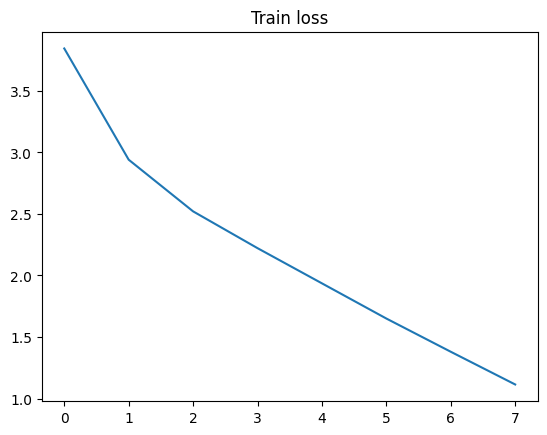

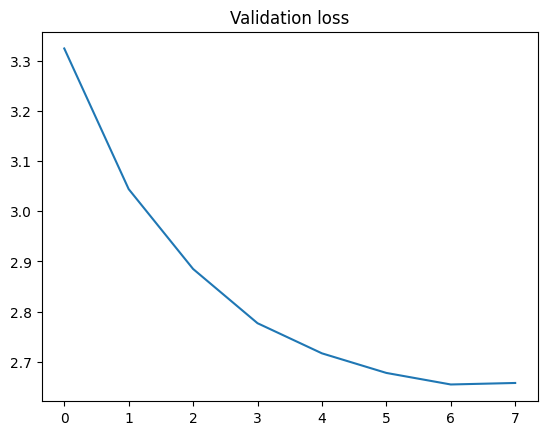

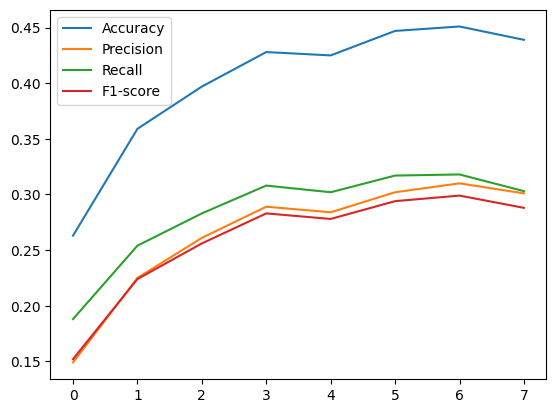

In [11]:
launch(train_loader=train_loader_mel, val_loader=val_loader_mel, num_epochs=8, spectrogram_type='mel')

In [12]:
loss_list = []
loss_list_val = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

loss_total = []
loss_total_val = []
accuracy_total = []
precision_total = []
recall_total = []
f1_total = []

# Model training on the spectral contrast

Iteration: 305 / 305
Validating...
Epoch 1/7, Train loss: 4.327, Validation loss: 4.055, Accuracy: 0.137, Precision: 0.058, Recall: 0.097, F1-score: 0.065

Iteration: 305 / 305
Validating...
Epoch 2/7, Train loss: 3.779, Validation loss: 3.851, Accuracy: 0.174, Precision: 0.087, Recall: 0.126, F1-score: 0.092

Iteration: 305 / 305
Validating...
Epoch 3/7, Train loss: 3.572, Validation loss: 3.777, Accuracy: 0.173, Precision: 0.085, Recall: 0.127, F1-score: 0.091

Iteration: 305 / 305
Validating...
Epoch 4/7, Train loss: 3.424, Validation loss: 3.718, Accuracy: 0.191, Precision: 0.109, Recall: 0.137, F1-score: 0.110

Iteration: 305 / 305
Validating...
Epoch 5/7, Train loss: 3.275, Validation loss: 3.670, Accuracy: 0.199, Precision: 0.113, Recall: 0.144, F1-score: 0.114

Iteration: 305 / 305
Validating...
Epoch 6/7, Train loss: 3.089, Validation loss: 3.643, Accuracy: 0.216, Precision: 0.122, Recall: 0.147, F1-score: 0.123

Iteration: 305 / 305
Validating...
Epoch 7/7, Train loss: 2.903,

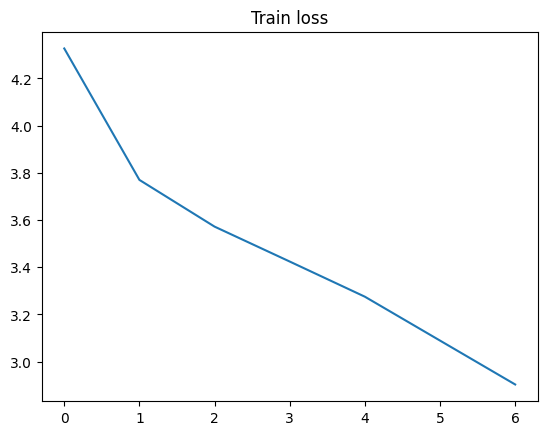

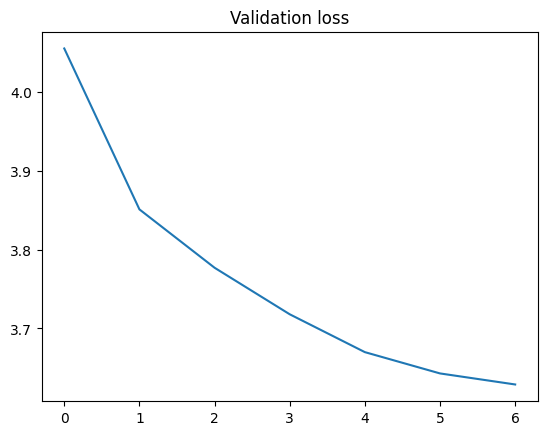

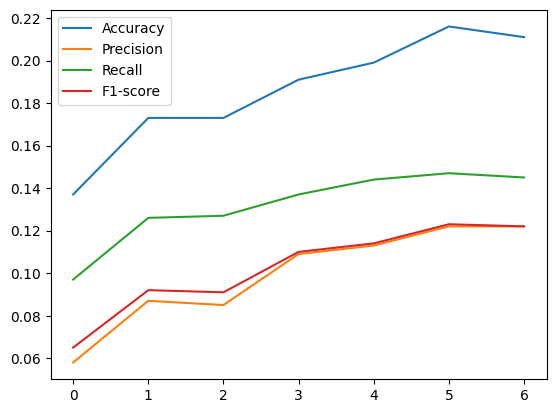

In [13]:
launch(train_loader=train_loader_contrast, val_loader=val_loader_contrast, num_epochs=7, spectrogram_type='sc')

# Model training on the constant-Q spectrogram

Iteration 305/305
Validating...
Epoch 1/7, Train loss: 4.165, Validation loss: 3.800, Accuracy: 0.178, Precision: 0.097, Recall: 0.130, F1-score: 0.101

Iteration 305/305
Validating...
Epoch 2/7, Train loss: 3.504, Validation loss: 3.586, Accuracy: 0.219, Precision: 0.128, Recall: 0.160, F1-score: 0.131

Iteration 305/305
Validating...
Epoch 3/7, Train loss: 3.219, Validation loss: 3.491, Accuracy: 0.244, Precision: 0.145, Recall: 0.180, F1-score: 0.147

Iteration 305/305
Validating...
Epoch 4/7, Train loss: 2.973, Validation loss: 3.431, Accuracy: 0.249, Precision: 0.164, Recall: 0.181, F1-score: 0.159

Iteration 305/305
Validating...
Epoch 5/7, Train loss: 2.747, Validation loss: 3.385, Accuracy: 0.275, Precision: 0.167, Recall: 0.200, F1-score: 0.169

Iteration 305/305
Validating...
Epoch 6/7, Train loss: 2.499, Validation loss: 3.365, Accuracy: 0.274, Precision: 0.189, Recall: 0.200, F1-score: 0.180

Iteration 305/305
Validating...
Epoch 7/7, Train loss: 2.237, Validation loss: 3.3

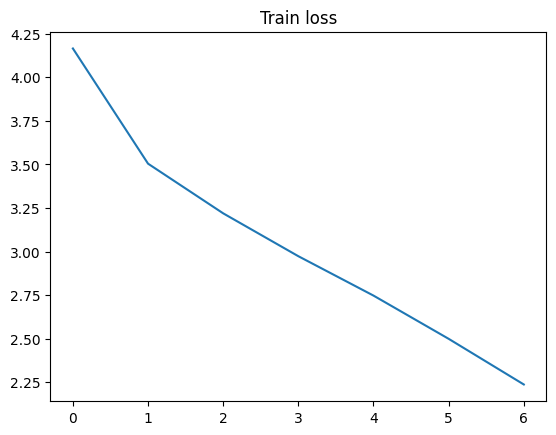

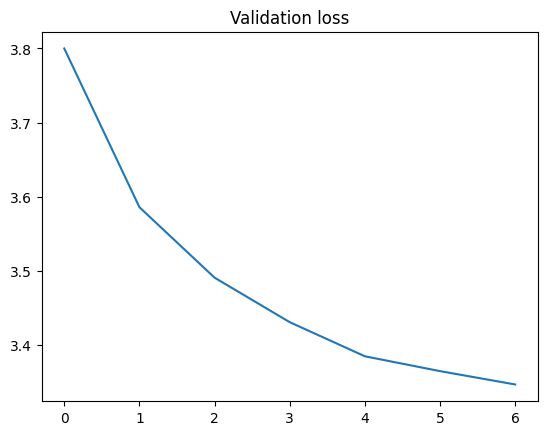

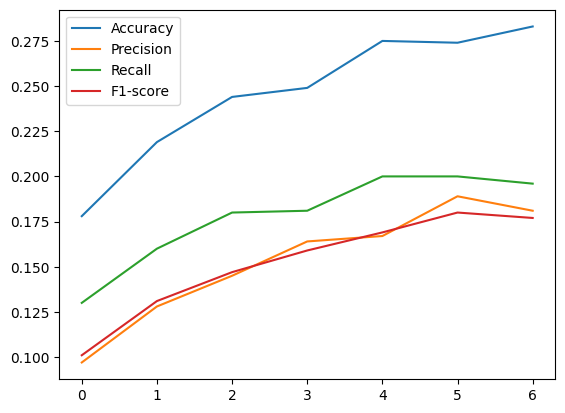

In [15]:
launch(train_loader=train_loader_constantQ, val_loader=val_loader_constantQ, num_epochs=7, spectrogram_type='cqt')

# Model training on the short-time fourier transform spectrogram

Iteration 305/305
Validating...
Epoch 1/8, Train loss: 3.944, Validation loss: 3.397, Accuracy: 0.260, Precision: 0.143, Recall: 0.180, F1-score: 0.145

Iteration 305/305
Validating...
Epoch 2/8, Train loss: 3.026, Validation loss: 3.153, Accuracy: 0.323, Precision: 0.203, Recall: 0.236, F1-score: 0.201

Iteration 305/305
Validating...
Epoch 3/8, Train loss: 2.617, Validation loss: 2.989, Accuracy: 0.380, Precision: 0.238, Recall: 0.263, F1-score: 0.235

Iteration 305/305
Validating...
Epoch 4/8, Train loss: 2.290, Validation loss: 2.875, Accuracy: 0.409, Precision: 0.267, Recall: 0.285, F1-score: 0.260

Iteration 305/305
Validating...
Epoch 5/8, Train loss: 2.000, Validation loss: 2.802, Accuracy: 0.417, Precision: 0.274, Recall: 0.296, F1-score: 0.269

Iteration 305/305
Validating...
Epoch 6/8, Train loss: 1.713, Validation loss: 2.771, Accuracy: 0.422, Precision: 0.279, Recall: 0.294, F1-score: 0.271

Iteration 305/305
Validating...
Epoch 7/8, Train loss: 1.455, Validation loss: 2.7

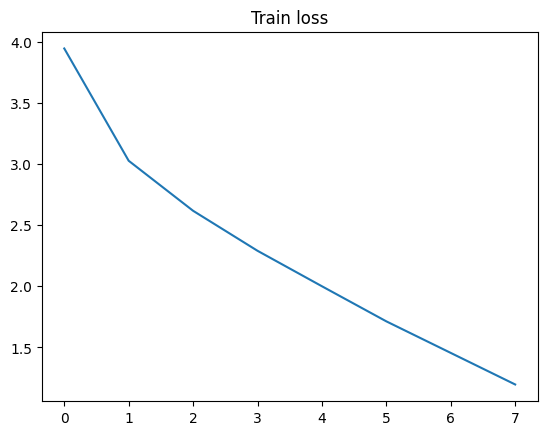

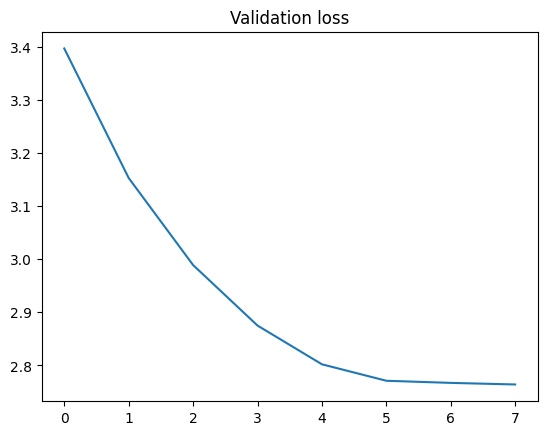

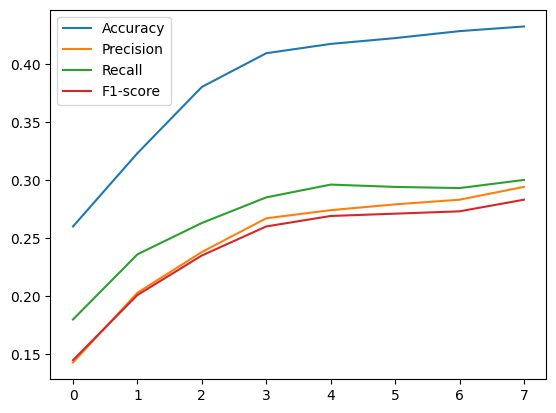

In [17]:
launch(train_loader=train_loader_stft, val_loader=val_loader_stft, num_epochs=8, spectrogram_type='stft')

# Model training on the chroma contrast

Iteration 305/305
Validating...
Epoch 1/5, Train loss: 4.428, Validation loss: 4.343, Accuracy: 0.122, Precision: 0.056, Recall: 0.088, F1-score: 0.060

Iteration 305/305
Validating...
Epoch 2/5, Train loss: 3.994, Validation loss: 4.105, Accuracy: 0.173, Precision: 0.089, Recall: 0.122, F1-score: 0.091

Iteration 305/305
Validating...
Epoch 3/5, Train loss: 3.714, Validation loss: 3.979, Accuracy: 0.190, Precision: 0.109, Recall: 0.136, F1-score: 0.108

Iteration 305/305
Validating...
Epoch 4/5, Train loss: 3.477, Validation loss: 3.886, Accuracy: 0.221, Precision: 0.126, Recall: 0.152, F1-score: 0.125

Iteration 305/305
Validating...
Epoch 5/5, Train loss: 3.240, Validation loss: 3.817, Accuracy: 0.239, Precision: 0.138, Recall: 0.173, F1-score: 0.140


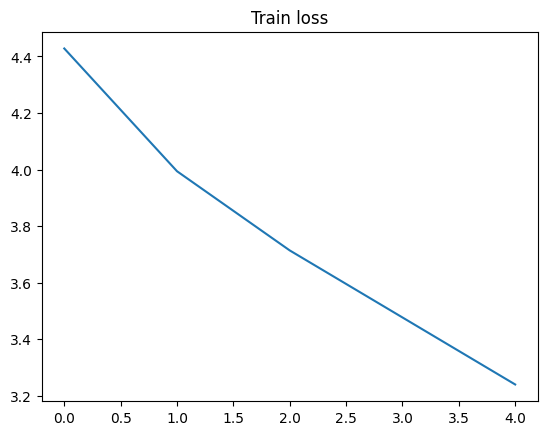

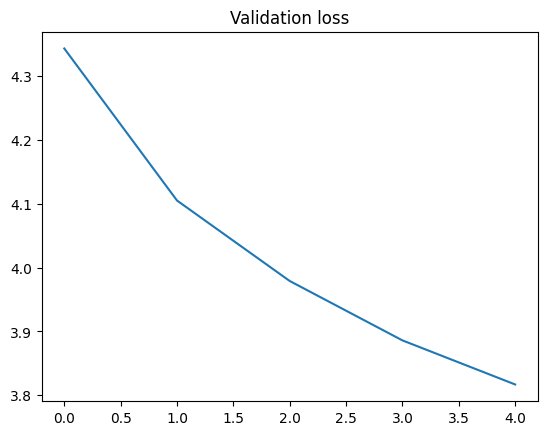

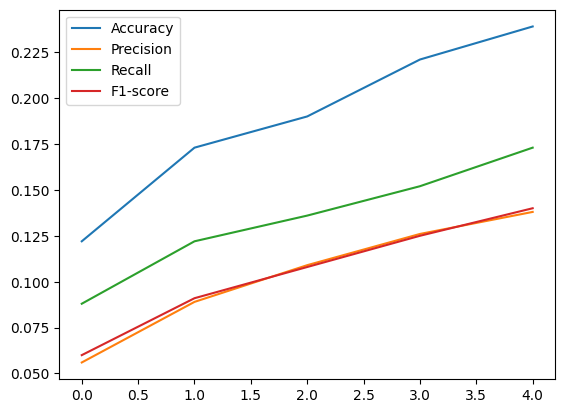

In [22]:
launch(train_loader=train_loader_chroma, val_loader=val_loader_chroma, num_epochs=5, spectrogram_type='chroma')

### As we can see, training on the mel spectrogram is the best, the results on the short-time fourier transform spectrogram's are close to it. Let's do an experiment:

# Model Training with label smoothing

In [23]:
loss_list = []
loss_list_val = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

loss_total = []
loss_total_val = []
accuracy_total = []
precision_total = []
recall_total = []
f1_total = []

In [24]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        n = pred.size(1)
        smoothed_labels = torch.full(size=(target.size(0), n), fill_value=self.smoothing / (n - 1)).to(pred.device)
        smoothed_labels.scatter_(dim=1, index=target.unsqueeze(1), value=1 - self.smoothing)
        log_probs = nn.functional.log_softmax(pred, dim=1)
        loss = -torch.sum(smoothed_labels * log_probs, dim=1).mean()
        return loss

def launch_ls(train_loader, val_loader, num_epochs=9, spectrogram_type='mel'):    
    model = EfficientNetGray(num_classes=182).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
    
    train_model(train_loader, val_loader, model, criterion, optimizer, num_epochs=num_epochs)
    
    torch.save(model.state_dict(), f'EfficientNet_weights{num_epochs}_{spectrogram_type}.pth')

Iteration 305/305
Validating...
Epoch 1/9, Train loss: 4.101, Validation loss: 3.557, Accuracy: 0.287, Precision: 0.164, Recall: 0.200, F1-score: 0.166

Iteration 305/305
Validating...
Epoch 2/9, Train loss: 3.353, Validation loss: 3.394, Accuracy: 0.346, Precision: 0.209, Recall: 0.247, F1-score: 0.211

Iteration 305/305
Validating...
Epoch 3/9, Train loss: 3.009, Validation loss: 3.299, Accuracy: 0.384, Precision: 0.247, Recall: 0.276, F1-score: 0.245

Iteration 305/305
Validating...
Epoch 4/9, Train loss: 2.745, Validation loss: 3.203, Accuracy: 0.445, Precision: 0.303, Recall: 0.323, F1-score: 0.296

Iteration 305/305
Validating...
Epoch 5/9, Train loss: 2.499, Validation loss: 3.140, Accuracy: 0.450, Precision: 0.303, Recall: 0.331, F1-score: 0.300

Iteration 305/305
Validating...
Epoch 6/9, Train loss: 2.261, Validation loss: 3.102, Accuracy: 0.459, Precision: 0.309, Recall: 0.328, F1-score: 0.303

Iteration 305/305
Validating...
Epoch 7/9, Train loss: 2.034, Validation loss: 3.0

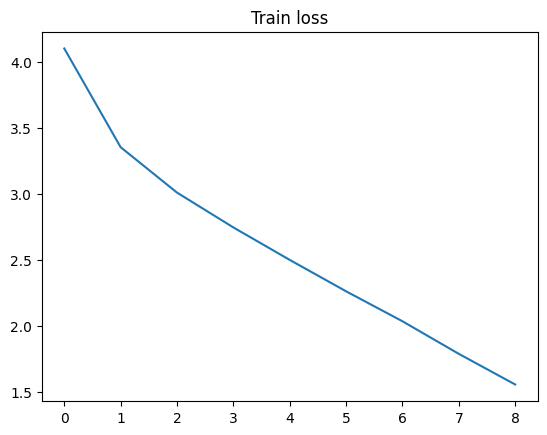

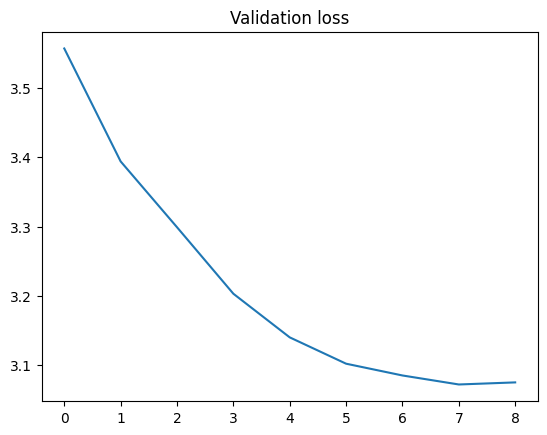

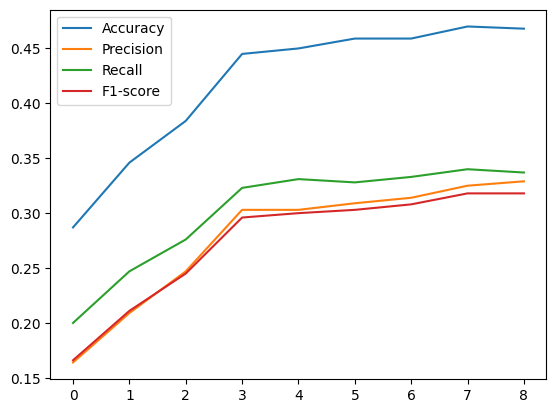

In [26]:
launch_ls(train_loader=train_loader_mel, val_loader=val_loader_mel, num_epochs=9, spectrogram_type='mel')

# Model training with augmentations

Iteration 305/305
Validating...
Epoch 1/6, Train loss: 3.879, Validation loss: 3.861, Accuracy: 0.203, Precision: 0.119, Recall: 0.140, F1-score: 0.116

Iteration 305/305
Validating...
Epoch 2/6, Train loss: 3.062, Validation loss: 3.385, Accuracy: 0.321, Precision: 0.190, Recall: 0.227, F1-score: 0.192

Iteration 305/305
Validating...
Epoch 3/6, Train loss: 2.695, Validation loss: 3.198, Accuracy: 0.348, Precision: 0.228, Recall: 0.243, F1-score: 0.220

Iteration 305/305
Validating...
Epoch 4/6, Train loss: 2.398, Validation loss: 3.055, Accuracy: 0.386, Precision: 0.256, Recall: 0.273, F1-score: 0.249

Iteration 305/305
Validating...
Epoch 5/6, Train loss: 2.128, Validation loss: 2.962, Accuracy: 0.400, Precision: 0.270, Recall: 0.276, F1-score: 0.259

Iteration 305/305
Validating...
Epoch 6/6, Train loss: 1.892, Validation loss: 2.877, Accuracy: 0.443, Precision: 0.307, Recall: 0.314, F1-score: 0.295


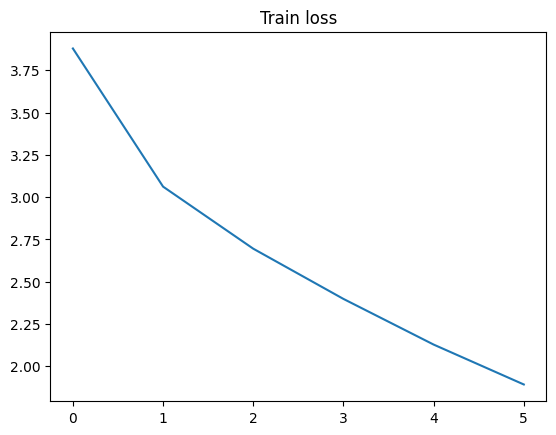

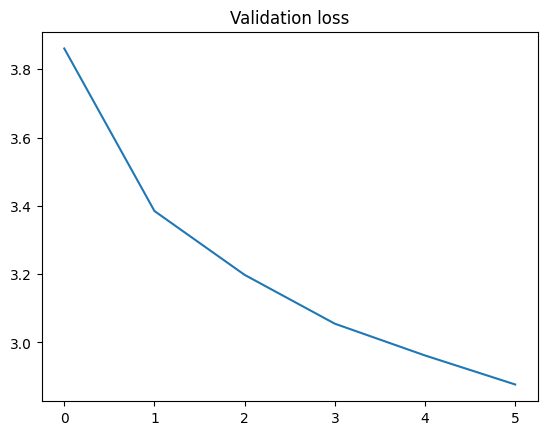

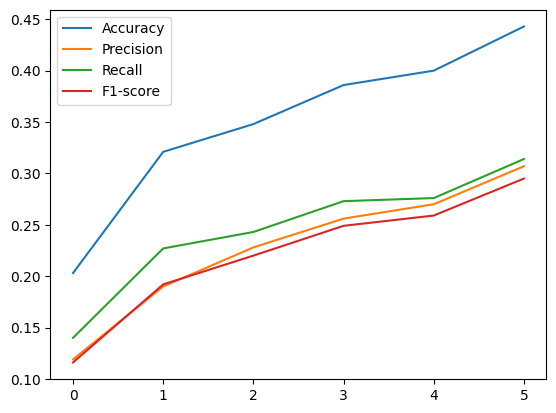

In [28]:
launch(train_loader=train_loader_mel_aug, val_loader=val_loader_mel, num_epochs=6, spectrogram_type='mel')